<a href="https://colab.research.google.com/github/JoseMauricioBazagoitiaAyllon/Inteligencia-Artificial-II/blob/main/PrimerParcialPregunta1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
import re
from skimage import color

In [ ]:
#dataset https://drive.google.com/drive/folders/1YWZMzSs_FXsgQFJoG5h2-jTgDEHKM2fr?usp=sharing
path = '/content/drive/MyDrive/IA2/Dataset_basura/'
path1 = '/content/drive/MyDrive/IA2/Dataset_basura_test/'
clases = os.listdir(path);
clases1 = os.listdir(path1);
print(clases)
print(clases1)

['metales', 'cartones', 'botellas_de_plastico', 'Plastoformos', 'papel', 'BolsasPlasticas']
['metales', 'cartones', 'papel', 'botellas_de_plastico', 'Plastoformos', 'BolsasPlasticas']


In [ ]:
imgs, labels = [], []

for i, lab in enumerate(clases):
  paths = os.listdir(f'{path}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{path}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: metales. Imágenes: 208
Categoría: cartones. Imágenes: 250
Categoría: botellas_de_plastico. Imágenes: 1
Categoría: Plastoformos. Imágenes: 265
Categoría: papel. Imágenes: 674
Categoría: BolsasPlasticas. Imágenes: 72


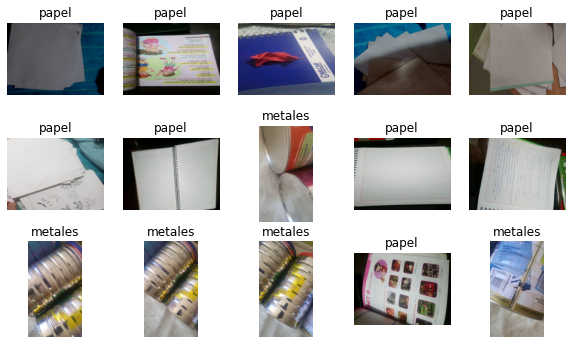

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(clases[labels[ix]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.1, stratify=labels)

len(train_imgs), len(test_imgs)

(793, 89)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(793, 89)

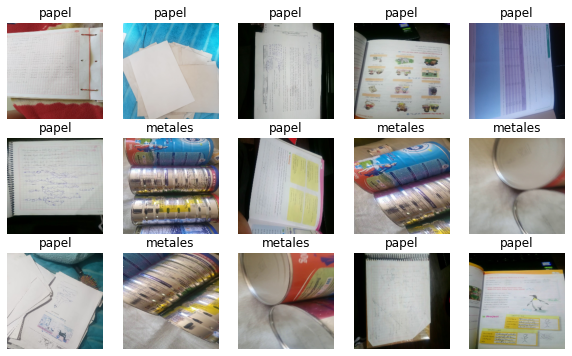

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(clases[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [ ]:
import torchvision
alexNet = torchvision.models.AlexNet()
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in alexNet.parameters():
        param.requires_grad=False

In [ ]:
alexNet.classifier[6] = torch.nn.Linear(4096, 6)

In [ ]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=6, pretrained=False, freeze=False):
    super().__init__()
    # descargamos alexNet
    alexNet = torchvision.models.AlexNet()
    # nos quedamos con todas las capas menos la última
    self.alexNet = torch.nn.Sequential(*list(alexNet.children())[:-1])
    if freeze:
      for param in self.alexNet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación

  def forward(self, x):
    x = self.alexNet(x)
    x = x.view(x.shape[0], -1)
    return x

  def unfreeze(self):
    for param in self.alexNet.parameters():
        param.requires_grad=True

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 4.04357 val_acc 0.03371: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 1/15 loss 7.67390 val_loss 4.04357 acc 0.04447 val_acc 0.03371


val_loss 2.12178 val_acc 0.13483: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 2/15 loss 3.05950 val_loss 2.12178 acc 0.08149 val_acc 0.13483


val_loss 2.00372 val_acc 0.15730: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Epoch 3/15 loss 2.13122 val_loss 2.00372 acc 0.13250 val_acc 0.15730


val_loss 1.96215 val_acc 0.17978: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 4/15 loss 2.01684 val_loss 1.96215 acc 0.18500 val_acc 0.17978


val_loss 1.88286 val_acc 0.32584: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 5/15 loss 1.93525 val_loss 1.88286 acc 0.29745 val_acc 0.32584


val_loss 1.76004 val_acc 0.47191: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch 6/15 loss 1.80886 val_loss 1.76004 acc 0.46817 val_acc 0.47191


val_loss 1.28960 val_acc 0.67416: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 7/15 loss 1.55918 val_loss 1.28960 acc 0.63712 val_acc 0.67416


val_loss 0.94325 val_acc 0.73034: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 8/15 loss 1.18318 val_loss 0.94325 acc 0.73716 val_acc 0.73034


val_loss 0.88741 val_acc 0.80899: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 9/15 loss 0.92364 val_loss 0.88741 acc 0.75370 val_acc 0.80899


val_loss 0.73062 val_acc 0.79775: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 10/15 loss 0.95509 val_loss 0.73062 acc 0.75933 val_acc 0.79775


val_loss 0.78666 val_acc 0.79775: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 11/15 loss 0.80431 val_loss 0.78666 acc 0.77091 val_acc 0.79775


val_loss 0.64763 val_acc 0.79775: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Epoch 12/15 loss 0.71865 val_loss 0.64763 acc 0.78683 val_acc 0.79775


val_loss 0.67969 val_acc 0.80899: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 13/15 loss 0.65080 val_loss 0.67969 acc 0.80433 val_acc 0.80899


val_loss 0.53418 val_acc 0.80899: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 14/15 loss 0.65995 val_loss 0.53418 acc 0.81288 val_acc 0.80899


val_loss 0.59409 val_acc 0.84270: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Epoch 15/15 loss 0.59122 val_loss 0.59409 acc 0.82183 val_acc 0.84270
